<div style="text-align: center;">
    <h1 style="color: red;">Vision Transformers</h1>

    
    
</div>

## I - Introduction

L'architecture des transformers est à la base des Large Language Models(LLM) comme GPT qui nous aide désormais tous les jours pour réaliser de nombreuses tâches allant de la traduction à la génération de texte. 
Toutefois, les transformers ne sauraient rester confiner au langage. 
Le papier de  Dosovitskiy et al(2021), An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale présentent l'application de ce type de modèle pour le domaine de la vision par ordinateur, et plus précisément, la classification d'images.
Quand bien même les mots et les images ne semblent pas avoir beaucoup en commun, nous allons voir à travers le détail de la méthode des Vision transformers (ViT) que dans les deux cas leur sens caché peut être découvert et analysé.
Dans ce notebook, nous suivrons ensemble une progression linéaire commençant du pre-processing des images jusqu'à l'entrainement du modèle de transformeur. Ainsi, nous n'échapperons pas à une solide partie sur l'architecture du transformeur, en particulier l'encodeur, qui est au coeur du sujet du notebook.

![Modèle du Vision Transformer](/Users/blechardoy/Documents/Github/notebook_SDD/images/ViT-model.png)

## II - the ViT model

### a) Découpage en patch

Les transformeurs sont des modèles de type séquence-à-séquence, c'est à dire qu'ils prennent une séquence en entrée (souvent une phrase donc une séquence de mots) et renvoient une autre séquence en sortie. Pour pouvoir appliquer ce type d'architecture à des images, il faut tout d'abord les transformer en séquence. Pour ce faire, l'idée est de découper l'image en patch de taille carré fixe, puis de les accoler les uns à la suite des autres. Nous avons alors une image vectorisée de taille $T*PT*C$ qui n'est pas encore sous la bonne forme. Il reste donc à aplatir chacun des patchs en concaténant chacune des lignes des 3 channels pour obtenir des patchs de taille $\mathbb{R}^{T^2 \cdot C}$

![Illustration du mécanisme de patching](/Users/blechardoy/Documents/Github/notebook_SDD/images/patching-VitT.jpeg)

Par la suite, de la même manière que pour les séquence de mots, il va falloir représenter chacun des patchs obtenu par un vecteur caché encapsulant l'information contenu localement dans cette partie de l'image. c'est une étape importante car cela permet au modèle de manipuler les infos contenus dans les patchs et initialise le prochain processus d'attention qui fait la particularité des transformeurs. 
L'encapsulation, ou embedding en anglais, est dans les faits une projection sur un espace de dimension D (la dimension que l'on veut pour nos vecteurs) grâce à une couche linéaire de réseau de neurones que nous connaissons bien. L'intérêt de cette étape est multiple : 
- Le vecteur nouvellement obtenu peut maintenant être utilisé comme entrée d'un transformeur où il fera l'objet du processus d'attention.
- L'information contenu dans un objet de $\mathbb{R}^{T^2 \cdot C}$ est condensé en un vecteur de $ℝ^E$ avec E la taille des embeddings
- L'information contenu est extraite sous forme de caractéristiques pertinentes pour la représentation du patch de l'image.

$$
Z = W X + b
$$

Avec :
- W de taille  $D * T^2C$
- b de taille $\mathbb{R}^D$


L'important est que la matrice des poids et le vecteur de biais soit les même pour réaliser l'encapsulation de chacun des patchs. Nous obtenons alors une séquence de vecteurs pour l'image correspondant aux embeddings de chacun des patchs de l'image. Cela ouvre donc la possibilité d'utiliser cette entrée dans un modèle de transformeur.




![Application de la couche dense suivi de l'encapsulation de position](/Users/blechardoy/Documents/Github/notebook_SDD/images/encapsulation-position.jpeg)

Testons sur le dataset OxfordIIITPet comprenant des photos de chats et de chiens afin de réaliser notre patching et notre position embedding. Nous utiliserons également ce dataset pour réaliser la classification dans la suite du notebook 

100%|██████████| 792M/792M [03:32<00:00, 3.73MB/s] 


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:06<00:00, 2.76MB/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet
Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: .


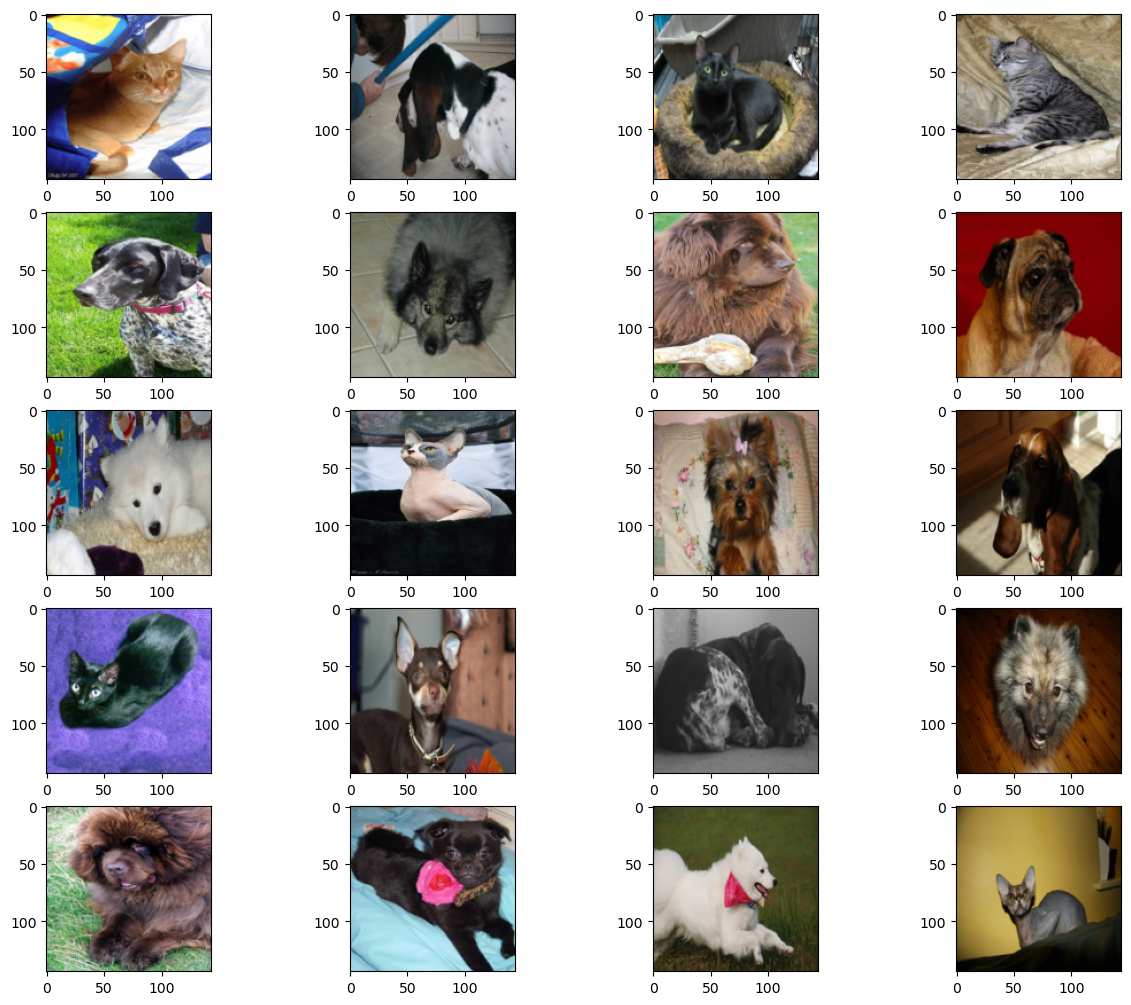

In [1]:
import einops
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

def show_images(images, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(dataset) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

# 200 images for each pet
dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(dataset)

In [35]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
from einops import rearrange
import math


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 16, emb_size = 128, img_size =144):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
        self.position_embedding = self.get_sinusoidal_position_embedding(img_size, emb_size)

    def get_sinusoidal_position_embedding(self, img_size, emb_size):
        """
        Calcule un embedding sinusoidal pour les positions.
        Args:
            img_size: La taille de l'image (hauteur/largeur, supposée carrée).
            emb_size: La taille de l'espace d'embedding (dim).
        """
        position = torch.arange(0, (img_size // self.patch_size) ** 2).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * -(math.log(10000.0) / emb_size))
        pe = torch.zeros((position.size(0), emb_size))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.unsqueeze(0)  # Ajoute une dimension pour le batch_size

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
                # Ajout de l'encodage de position sinusoidal
        x = x + self.position_embedding
        return x

def visualize_patches(x: Tensor, patch_size: int):
    """
    Affiche les patches d'une image en ligne.
    Args:
        x: Tensor de forme (1, 3, h, w)
        patch_size: Taille des patches (ex: 16x16)
    """

    # Découper en patches
    patches = rearrange(x, 'b c (h p1) (w p2) -> b (h w) c p1 p2', p1=patch_size, p2=patch_size)
    patches = patches.squeeze(0)  # Limiter à 8 patches pour affichage
    print(patches.shape)
    # Affichage
    plt.figure(figsize=(15, 5))
    for i, patch in enumerate(patches):
        # print(patch.shape)
        patch = patch.squeeze(0)
        # print(patch.shape)
        plt.subplot(1, len(patches), i + 1)
        plt.imshow(to_pil_image(patch))
        plt.axis('off')
    plt.show()



# Run a quick test
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

# Test de visualisation
visualize_patches(sample_datapoint, patch_size=16)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 81, 128])
torch.Size([81, 3, 16, 16])


Avec l'exemple ci-dessus, on aboutit à nos images transformées en séquence contenant une représentation non seulement de l'information propre aux pixels de chaque patch mais aussi de la position de chacun de ceux-ci que nous avions perdu en découpant et aplatissant. La dernière étape de cette phase est de rajouter un emplacement CLS dans notre séquence. l y a un une particularité propre aux transformeurs utilisé pour de la classification. En effet, celle-ci ne se fait pas à partir des vecteurs cachés propre à chaque patchs, mais sur un seul vecteur  que l'on nomme un CLS(classification) token rajouté à la séquence au moment de l'embedding. Généralement rajoutée en première position, on initilialise ce vecteur d'embedding ne correspondant à aucun patch de manière aléatoire. L'idée est que, dans la suite, nous allons apprendre à analyser les patchs dans la séquence à travers des représentations liées au mécanisme de l'attention. Plus les représentations sont bonnes, plus le modèle sera en mesure de comprendre l'information contenue dans l'image sous le prisme de la tâche de classification. Ainsi, ce vecteur additionnelle va servir à accueillir l'information pertinente extraite par les têtes d'attention afin de servir d'input pour la classification. De la même manière que les autres vecteurs d'encapsulation, on associe à ce vecteur une encapsulation de position pour indiquer au modèle que ce vecteur ne fait pas partie de l'image.

![Insertion du CLS-token](/Users/blechardoy/Documents/Github/notebook_SDD/images/CLS_token.jpeg)

## II - the ViT model

 


Mais qu'est ce qu'un transformeur exactement ? Nous devons nous plonger dans les méchanismes de ce modèle afin de comprendre quelles transformations nos séquences (images) vont subir et quelles informations nous allons en retirer. Le premier processus à bien appréhender est celui de l'attention qui a été défini pour la première fois dans le travail de Vaswani et al (2017) "Attention is all you need". Dans le principe, L'attention vise à déterminer et quantifier les relations/liens intrinsèques entre les divers éléments d'une séquence. Cela est très facile à illustrer dans le cadre des transformeurs pour les tâches de NLP. En effet, la phrase : " Je me suis connecté à mon port tout en me rendant au port" par exemple pose un véritable problème lorsqu'il s'agit de comprendre le sens des deux mots "port". Notre cerveau parvient inconsciemment à lier le premier "port" au verbe "connecté" qui indique plutot un port internet, ou encore le second "port" au participe présent "rendant" et au pronom possessif "me" pour indiquer un lieu donc un port maritime. Comment peut-on alors modéliser ce processus mathématiquement ?

![Mécanisme de l'attention](/Users/blechardoy/Documents/Github/notebook_SDD/images/attention.jpeg)

Sur le schéma, on part des séquences de vecteurs d'embedding des patchs en vert sur lesquels nous allons appliquer 3 couches linéaires différentes afin d'obtenir 3 représentations différentes de taille.

$$
V = xW_v
$$

$$
K = xW_k
$$

$$
Q = xW_q
$$

Avec :
- V la matrice de valeur qui permet de pondérer l'importance de l'information contenue dans chaque patch
- K le vecteur des clés qui représente la position et les charactéristiques de tous les patch pour les comparer aux requêtes
- Q le vecteur des requêtes qui représente la position et les charactéristiques voulue de chaque patch

A l'image d'un moteur de recherche, chaque vecteur dans la matrice des requêtes est associé à la représentation de chaque patch contenue dans la matrice des clés. On en déduit par produit scalaire un score d'attention brut qui quantifie le rapprochement de l'information entre la requête et chacune des autres encaspulations (dont la sienne). Ce score est généralement ramené au nombre total d'éléments dans la séquence, à savoir la dimension de l'espace des clés :

$$
\text{attention\_score}(Q,K) = \frac{Q.K^T}{d_k}
$$ 

Ensuite, on normalise nos scores attention à travers une couche softmax pour les ramener entre 0 et 1. 

$$
\text{attention\_logits}(Q,K) = Softmax(\text{attention\_score}(Q,K)) 
$$

Finalement, on utilise la matrice des valeurs pour pondérer les scores d'attention par l'importance estimée de l'information contenue dans chacun des patchs auxquelles ils se rapportent.

$$
\text{sortie\_attention}(Q,K,V) = \text{attention\_logits}(Q,K).V
$$

L'idée pour la suite est que le score d'attention, produit grâce aux différents poids des 3 couches linéaires produisant valeurs, clés et requêtes, sert à réaliser la classification. En retour, on entraine les couches linéaires pour avoir in fine une performance de classification la plus élevée possible. Il faut voir cela comme l'apprentissage des meilleurs représentations possibles des points d'intérêt de la séquence pour réaliser la tâche voulue.


 


In [33]:
import torch
import torch.nn as nn
from einops import rearrange

# Classe pour l'Attention expliquée ci-dessus
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.attn_layer = torch.nn.MultiheadAttention(embed_dim=dim,
                                                      num_heads=n_heads,
                                                      dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)
        self.layernorm = nn.LayerNorm(dim)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Appliquer les projections linéaires pour obtenir Q, K, et V
        q = self.q(x)  # [batch_size, seq_len, dim]
        k = self.k(x)  # [batch_size, seq_len, dim]
        v = self.v(x)  # [batch_size, seq_len, dim]

        # Réorganiser pour MultiheadAttention
        q = rearrange(q, 'b n d -> n b d')  # [seq_len, batch_size, dim]
        k = rearrange(k, 'b n d -> n b d')  # [seq_len, batch_size, dim]
        v = rearrange(v, 'b n d -> n b d')  # [seq_len, batch_size, dim]

        # Calcul de l'attention avec MultiheadAttention
        attn_output, attn_weights = self.attn_layer(q, k, v, average_attn_weights=False)  # [seq_len, batch_size, dim]

        attn_weights = attn_weights.squeeze(0)

        # Appliquer la normalisation de couche après l'attention
        return self.layernorm(attn_output), attn_weights

torch.Size([4, 81, 81])
attention_weights = torch.Size([4, 81, 81])
attention_weights = torch.Size([4, 81, 81])
attention_weights = torch.Size([4, 81, 81])
attention_weights = torch.Size([4, 81, 81])


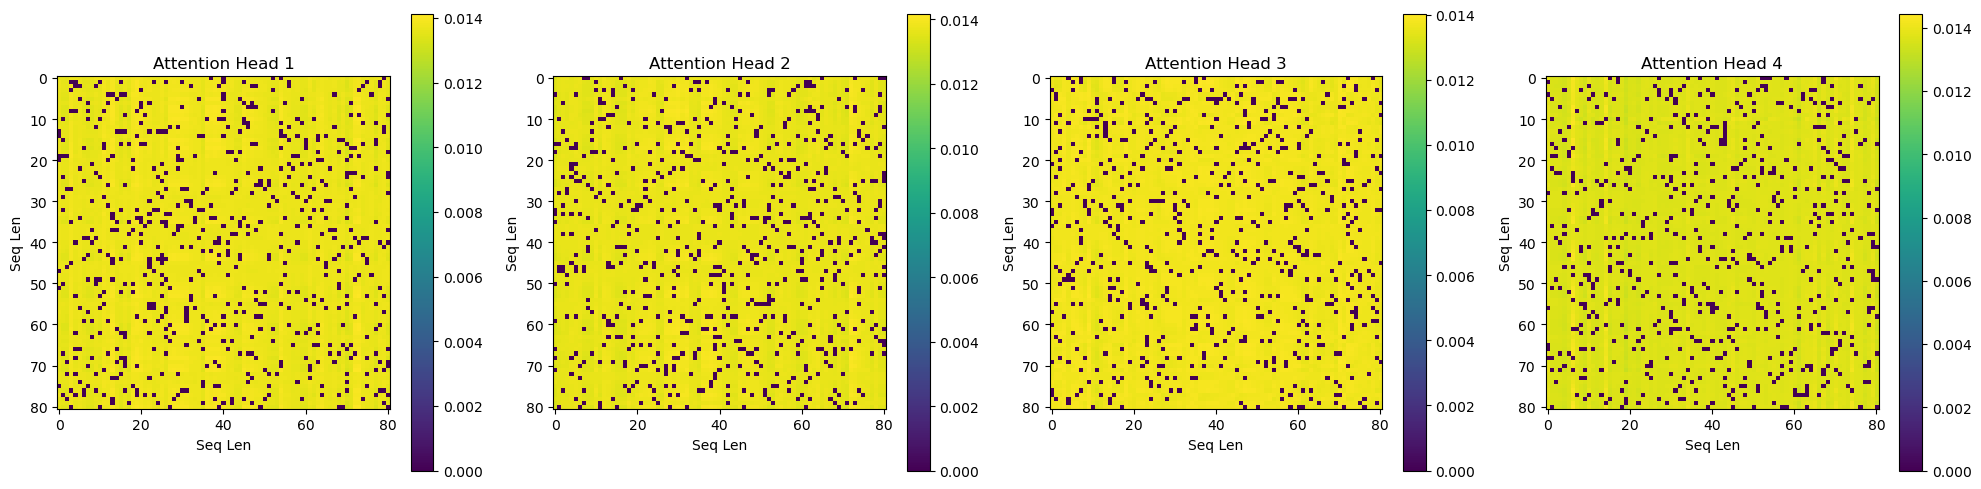

In [ ]:
attention_model = Attention(dim=128, n_heads=4, dropout=0.1)

attention_score, attention_weights = attention_model(embedding)


# Visualisation des scores d'attention pour chaque tête
fig, axes = plt.subplots(1, attention_model.n_heads, figsize=(20, 5))

# On boucle sur chaque tête et on affiche les scores d'attention
for i in range(attention_model.n_heads):
    # Récupérer les scores d'attention pour la tête i
    print("attention_weights =", attention_weights.shape)
    attn_head_weights = attention_weights[i].squeeze(0)  # Prendre la ième tête, la réduire à [seq_len, seq_len]

    # Afficher la heatmap pour cette tête
    ax = axes[i]
    im = ax.imshow(attn_head_weights.detach().numpy(), cmap='viridis', interpolation='nearest')
    ax.set_title(f"Attention Head {i+1}")
    ax.set_xlabel('Seq Len')
    ax.set_ylabel('Seq Len')
    
    # Ajouter une barre de couleur
    fig.colorbar(im, ax=ax)

# Afficher toutes les heatmaps côte à côte
plt.tight_layout()
plt.show()

In [ ]:
# Classe pour l'architecture du Vision Transformer avec classification
class VisionTransformer(nn.Module):
    def __init__(self, num_patches, patch_dim, emb_dim, n_heads, n_layers, num_classes):
        super(VisionTransformer, self).__init__()
        
        # Ajout du token [CLS] au début de la séquence de patchs
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))  # Initialisation aléatoire
        self.positional_encoding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))  # Embedding de position
        
        # Embedding des patchs
        self.patch_embedding = nn.Linear(patch_dim, emb_dim)
        
        # Couches d'attention
        self.attention_blocks = nn.ModuleList(
            [Attention(emb_dim, n_heads, dropout=0.1) for _ in range(n_layers)]
        )
        
        # MLP de classification
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # x : [batch_size, num_patches, patch_dim]
        
        # Appliquer l'embedding sur les patchs
        x = self.patch_embedding(x)  # [batch_size, num_patches, emb_dim]
        
        # Ajouter le token [CLS] au début de la séquence
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)  # [batch_size, 1, emb_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [batch_size, num_patches+1, emb_dim]
        
        # Ajouter l'encodage positionnel
        x += self.positional_encoding
        
        # Passer à travers les blocs d'attention
        for attn_block in self.attention_blocks:
            x = attn_block(x)
        
        # Prendre la sortie du token [CLS] pour la classification
        cls_output = x[:, 0]  # [batch_size, emb_dim] (seulement le token [CLS])
        
        # Passer par le MLP pour obtenir les prédictions de classe
        logits = self.mlp_head(cls_output)  # [batch_size, num_classes]
        
        return logits